# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV598"

In [4]:
LV_AXIS_THRESHOLD = 3.5
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv598')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv598/lv598-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 13:57:41,068 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
1497,REACTOME_COLLAGEN_FORMATION,598,0.766211,0.003227,0.018913
1499,PID_SYNDECAN_1_PATHWAY,598,0.807975,0.001766,0.012023


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP016140, SRP055101, SRP058773, SRP060416, SRP009266, SRP057196, SRP050499, SRP055513, SRP007338, SRP009247, SRP060355, SRP013773, SRP006575, SRP035862, SRP055569, SRP017411, SRP067934, SRP041179, SRP011895, SRP058667, SRP066834, SRP064464, SRP042161, SRP015640, SRP052056, SRP042184, SRP012656, SRP019994, SRP002326, SRP050087, SRP041538, SRP015336, SRP065491, SRP058237, SRP027530, SRP033248, SRP039338, SRP063661, SRP033095, SRP013402, SRP042186, SRP060715, SRP014320, SRP041036, SRP036848, SRP041718, SRP047194, SRP019936, SRP003726, SRP017294, SRP032922, SRP007498, SRP049097, SRP033135, SRP042620, SRP014688, SRP036821, SRP028180, SRP023199, SRP064259, SRP027364, SRP055153, SRP063493, SRP027383, SRP012695, SRP014213, SRP058771, SRP007947, SRP062389, SRP019270, SRP051688, SRP004847, SRP045500, SRP065219, SRP057156, SRP027015, SRP056295, SRP033464, SRP057586, SRP044668, SRP057205, SRP055810, SRP045876, SRP064783, SRP063059, SRP035391, SRP032789, SRP021193, SRP028336, SRP034712, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (88 != 90)
  warnings.warn(


In [19]:
lv_data.shape

(7865, 159)

In [20]:
lv_data.head()

cell type                    age  \
project   run                                                           
SRP016140 SRR592745  corneal endothelial cells                    31y   
          SRR592746  corneal endothelial cells                    56y   
          SRR592747  corneal endothelial cells                    64y   
          SRR592748  corneal endothelial cells  gestation age 16-18wk   
          SRR592749  corneal endothelial cells  gestation age 16-18wk   

                    imortalization culture medium well number  \
project   run                                                   
SRP016140 SRR592745            NaN            NaN         NaN   
          SRR592746            NaN            NaN         NaN   
          SRR592747            NaN            NaN         NaN   
          SRR592748            NaN            NaN         NaN   
          SRR592749            NaN            NaN         NaN   

                    reprogramming time point (day) tonsil donor facs gating  \
project   run                                                                 
SRP016140 SRR592745                            NaN          NaN         NaN   
          SRR592746                            NaN          NaN         NaN   
          SRR592747                            NaN          NaN         NaN   
          SRR592748                            NaN          NaN         NaN   
          SRR592749                            NaN          NaN         NaN   

                    tissue c1 chip id  ... tumor type lvad support age (days)  \
project   run                          ...                                      
SRP016140 SRR592745    NaN        NaN  ...        NaN          NaN        NaN   
          SRR592746    NaN        NaN  ...        NaN          NaN        NaN   
          SRR592747    NaN        NaN  ...        NaN          NaN        NaN   
          SRR592748    NaN        NaN  ...        NaN          NaN        NaN   
          SRR592749    NaN        NaN  ...        NaN          NaN        NaN   

                    age (years) strain/background starting material  \
project   run                                                         
SRP016140 SRR592745         NaN               NaN               NaN   
          SRR592746         NaN               NaN               NaN   
          SRR592747         NaN               NaN               NaN   
          SRR592748         NaN               NaN               NaN   
          SRR592749         NaN               NaN               NaN   

                    differentiation sorting# scrb-seq variant#     LV598  
project   run                                                             
SRP016140 SRR592745             NaN      NaN               NaN  2.940702  
          SRR592746             NaN      NaN               NaN  1.931103  
          SRR592747             NaN      NaN               NaN  2.782813  
          SRR592748             NaN      NaN               NaN  3.361573  
          SRR592749             NaN      NaN               NaN  2.559625  

[5 rows x 159 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

imortalization                    1.870823
culture medium                    1.722935
age                               0.057225
cell type                         0.021674
well number                       0.015129
reprogramming time point (day)    0.015129
tag                               0.010357
read length                       0.005981
library type                      0.005981
brain region                      0.005914
isolate                           0.005914
facs gating                       0.005107
tonsil donor                      0.005107
trimester                         0.004583
knockdown                         0.004137
gestational age                   0.004102
Sex                               0.003513
clip antibody                     0.003265
final gtf2i mutation status       0.003252
who histotype                     0.003252
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type         0.021674
tissue subtype    0.001960
tissue            0.001792
cell subtype      0.001364
tissue type       0.001182
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "cell subtype",
        "tissue subtype",
        "tissue",
        "tissue type",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[0]

cell type cell subtype  \
project   run                                                     
SRP016140 SRR592748      corneal endothelial cells          NaN   
SRP055101 SRR1806591                   endothelial          NaN   
          SRR1806592                   endothelial          NaN   
SRP016140 SRR592745      corneal endothelial cells          NaN   
SRP055101 SRR1806590                   endothelial          NaN   
SRP016140 SRR592747      corneal endothelial cells          NaN   
SRP055101 SRR1806589                   endothelial          NaN   
SRP016140 SRR592749      corneal endothelial cells          NaN   
SRP055101 SRR1806588                   endothelial          NaN   
SRP016140 SRR592746      corneal endothelial cells          NaN   
SRP055101 SRR1806587                   endothelial          NaN   
SRP058773 SRR2042646                           NaN          NaN   
SRP060416 SRR2088253  tonsil Innate lymphoid cells          NaN   
          SRR2088202  tonsil Innate lymphoid cells          NaN   
          SRR2088278  tonsil Innate lymphoid cells          NaN   
SRP057196 SRR1974587                           OPC          NaN   
          SRR1974789                   endothelial          NaN   
SRP060416 SRR2088519  tonsil Innate lymphoid cells          NaN   
          SRR2088213  tonsil Innate lymphoid cells          NaN   
SRP050499 SRR2013752                           NaN          NaN   
SRP055513 SRR1818568                           NaN          NaN   
SRP060416 SRR2088240  tonsil Innate lymphoid cells          NaN   
          SRR2088669  tonsil Innate lymphoid cells          NaN   
          SRR2088270  tonsil Innate lymphoid cells          NaN   
SRP057196 SRR1974656                       neurons          NaN   

                     tissue subtype       tissue tissue type     LV598  
project   run                                                           
SRP016140 SRR592748             NaN          NaN         NaN  3.361573  
SRP055101 SRR1806591            NaN          NaN         NaN  3.256358  
          SRR1806592            NaN          NaN         NaN  3.057409  
SRP016140 SRR592745             NaN          NaN         NaN  2.940702  
SRP055101 SRR1806590            NaN          NaN         NaN  2.937767  
SRP016140 SRR592747             NaN          NaN         NaN  2.782813  
SRP055101 SRR1806589            NaN          NaN         NaN  2.670618  
SRP016140 SRR592749             NaN          NaN         NaN  2.559625  
SRP055101 SRR1806588            NaN          NaN         NaN  2.316222  
SRP016140 SRR592746             NaN          NaN         NaN  1.931103  
SRP055101 SRR1806587            NaN          NaN         NaN  1.840386  
SRP058773 SRR2042646            NaN          NaN         NaN  0.806370  
SRP060416 SRR2088253            NaN          NaN         NaN  0.718619  
          SRR2088202            NaN          NaN         NaN  0.528710  
          SRR2088278            NaN          NaN         NaN  0.475609  
SRP057196 SRR1974587            NaN  hippocampus         NaN  0.468860  
          SRR1974789            NaN  hippocampus         NaN  0.431542  
SRP060416 SRR2088519            NaN          NaN         NaN  0.431248  
          SRR2088213            NaN          NaN         NaN  0.401076  
SRP050499 SRR2013752            NaN          NaN         NaN  0.392389  
SRP055513 SRR1818568            NaN          eye         NaN  0.363322  
SRP060416 SRR2088240            NaN          NaN         NaN  0.360120  
          SRR2088669            NaN          NaN         NaN  0.346869  
          SRR2088270            NaN          NaN         NaN  0.327113  
SRP057196 SRR1974656            NaN       cortex         NaN  0.323787

In [26]:
# what is there in these projects?
lv_data.loc[["SRP058773"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

well number reprogramming time point (day)     LV598
project   run                                                            
SRP058773 SRR2042646          48                             10  0.806370
          SRR2042653           9                             10  0.217588
          SRR2042627          89                             10  0.188289
          SRR2042650          10                             10  0.110942
          SRR2042654          66                             10  0.090845
          SRR2042624          20                             10  0.083201
          SRR2042636          54                             10  0.065794
          SRR2042629          92                             10  0.047536
          SRR2042658          67                             10  0.038073
          SRR2042648          69                             10  0.035160

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type     LV598
project   run                                               
SRP016140 SRR592748      corneal endothelial cells  3.361573
SRP055101 SRR1806591                   endothelial  3.256358
          SRR1806592                   endothelial  3.057409
SRP016140 SRR592745      corneal endothelial cells  2.940702
SRP055101 SRR1806590                   endothelial  2.937767
SRP016140 SRR592747      corneal endothelial cells  2.782813
SRP055101 SRR1806589                   endothelial  2.670618
SRP016140 SRR592749      corneal endothelial cells  2.559625
SRP055101 SRR1806588                   endothelial  2.316222
SRP016140 SRR592746      corneal endothelial cells  1.931103
SRP055101 SRR1806587                   endothelial  1.840386
SRP058773 SRR2042646               NOT CATEGORIZED  0.806370
SRP060416 SRR2088253  tonsil Innate lymphoid cells  0.718619
          SRR2088202  tonsil Innate lymphoid cells  0.528710
          SRR2088278  tonsil Innate lymphoid cells  0.475609
SRP057196 SRR1974587                           OPC  0.468860
          SRR1974789                   endothelial  0.431542
SRP060416 SRR2088519  tonsil Innate lymphoid cells  0.431248
          SRR2088213  tonsil Innate lymphoid cells  0.401076
SRP050499 SRR2013752               NOT CATEGORIZED  0.392389

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            #             "adipocyte": "Adipocytes",
        }
    }
)

# plot_data = plot_data[plot_data[SELECTED_ATTRIBUTE] != "no cell"]

In [34]:
# add also tissue information to these projects
_srp_code = "SRP057196"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-6f1c7e491b69>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

25

In [40]:
attr_order[:5]

['corneal endothelial cells',
 'endothelial',
 'tonsil Innate lymphoid cells',
 'OPC (hippocampus)',
 'endothelial (hippocampus)']

## Plot

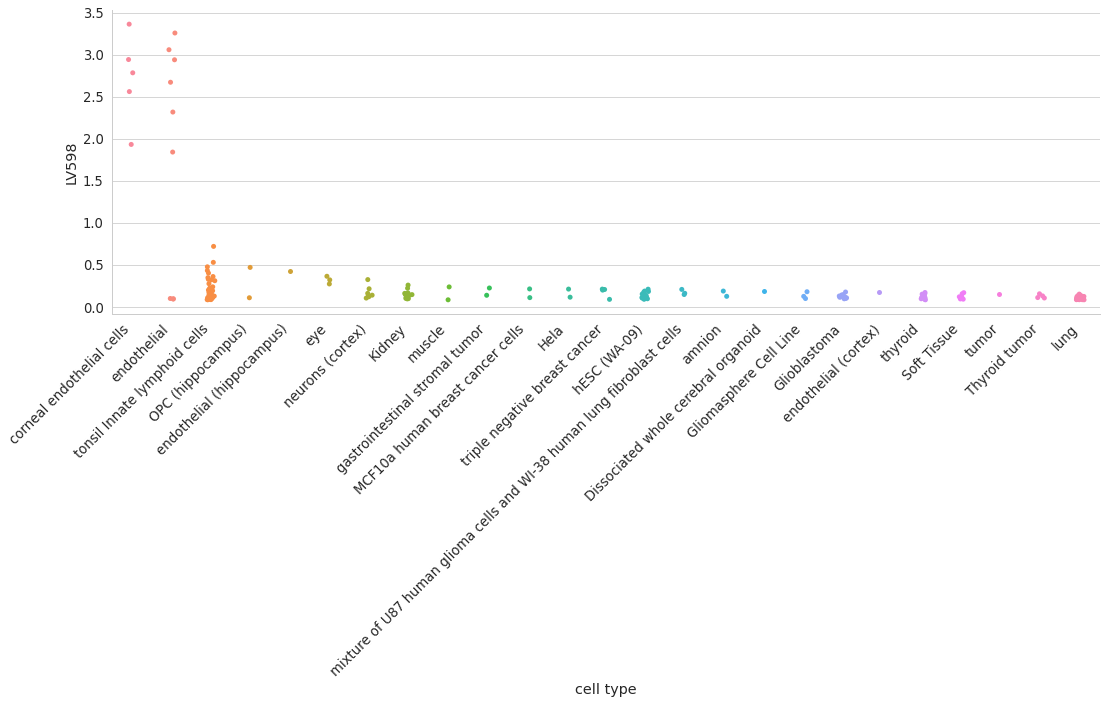

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)